# Hands-on Deep Learning Project. Instance segmentation with Mask-CNN




In this project, a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model will be finetuned to the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). The results will be compared to a [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf) model with [SqueezeNet](https://arxiv.org/abs/1602.07360) as a backbone. 

The dataset contains 170 images with 345 instances of pedestrians, and we will evaluate both models with the Average Precision. The project is based on and has parts of code from this [Torchvision tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) 


The link to the paper can be found [here](https://www.linkedin.com/posts/ignacio-perez-mahiques_pedrestrian-instance-segmentation-with-mask-activity-6841263932963856386-4BE_).

### Necessary imports and checking virtual machine

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the metrics of Average Precision for different for Intersection over Unions used in the Mask R-CNN paper.

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Since we are working in a virtual environment it is important to check the GPU type to contrast the performance of the algorithm with other applications

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Download the dataset


First, we download and extract the data, present in a zip file at https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

### Visualize the dataset

The data is structured as follows
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

One example of an image in the dataset, with its corresponding instance segmentation mask is shown below

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# we add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

### Write a custom Dataset class for this Dataset

So each image has a corresponding segmentation mask, where each color correspond to a different instance. We write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

The outputs of this dataset are as follows. It is important that they match to the torchvision requirements

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, a [Mask R-CNN](https://arxiv.org/abs/1703.06870) model will be used, which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a neural network that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

In this project, first we will finetune the model to our dataset and then change the backbone of a Faster R-CNN to decrease the memory usage and the training and predicting time. But first some tasks have to done in order to train the model.


### Training and evaluation helper functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [ ]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator


### Transforms and Dataset





In this section the dataset is divided on train, validation and test set. Moreover data augmentation is performed, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_val = PennFudanDataset('PennFudanPed', get_transform(train=False))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))


# split the dataset in train (80%, 136 images), val and test set (10%, 17 images each)
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:136])
dataset_val = torch.utils.data.Subset(dataset_test, indices[136:-17])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-17:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Finetuning the pretrained Mask R-CNN Model

#### With standard hyperparameters

Since the dataset class and the data transforms have been defined, we can instantiate them and define the model.

The hyperparameters used in this section to finetune the model are similar to the hyperparameters that were used to train initially the ResNet50

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

The model is trained for 10 epochs, evaluating on the validation set at the end of every epoch.

In [ ]:
# The training is in this case 10 epochs
num_epochs = 10
metric_logger = None
training_loss = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    training_loss[epoch] = metric_logger.loss.global_avg
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the val dataset
    coco_val = evaluate(model, data_loader_val, device=device)

# evaluate on the test dataset
coco = evaluate(model, data_loader_test, device=device)

#### Alternative hyperparameters

The same process is done for different hyperparameters and the results will be compared. In this case, the model is trained for 20 epoch with an ADAM optimizer.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
new_optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
new_lr_scheduler = torch.optim.lr_scheduler.StepLR(new_optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# The number of epochs are 20 with the alternative parameters
num_epochs = 20
new_metric_logger = None
new_training_loss = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    new_metric_logger = train_one_epoch(model, new_optimizer, data_loader, device, epoch, print_freq=10)
    new_training_loss[epoch] = new_metric_logger.loss.global_avg
    # update the learning rate
    new_lr_scheduler.step()
    # evaluate on the val dataset
    new_coco_val = evaluate(model, data_loader_val, device=device)

# evaluate on the test dataset
new_coco = evaluate(model, data_loader_test, device=device)

#### Comparing both models to the original Mask R-CNN model

First the models trained on the Penn-Fudan Dataset are compared.

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(training_loss, '-o', label='Standard training Loss')
plt.plot(new_training_loss, '-o', label='Alternative training Loss')
## Check bbox and segm losses training
# plt.plot(test_logger, '-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2,loc='upper center')

plt.subplot(2, 1, 2)
plt.scatter(0, coco.coco_eval["bbox"].stats[0], label='Standard AP bbox')
plt.scatter(0, coco.coco_eval["segm"].stats[0], label='Standard AP segm')
plt.scatter(1, new_coco.coco_eval["bbox"].stats[0], label='Alternative AP bbox')
plt.scatter(1, new_coco.coco_eval["segm"].stats[0], label='Alternative AP segm')
plt.xlabel('Optimizer')
plt.ylabel('mAP')
plt.legend(ncol=2,loc='lower center')
plt.gcf().set_size_inches(15, 10)
plt.show()

As it is shown on the plots the training convergence is better on the original hyperparameters but the accuracy is better on the alternative hyperparameters

In the table extracted from the paper, a comparison is made between this models and the original one trained on the COCO Dataset. The performance of the model on the Penn-Fudan dataset is outstanding but it should be taken into account that the dataset is simpler as the dataset used in the original model.

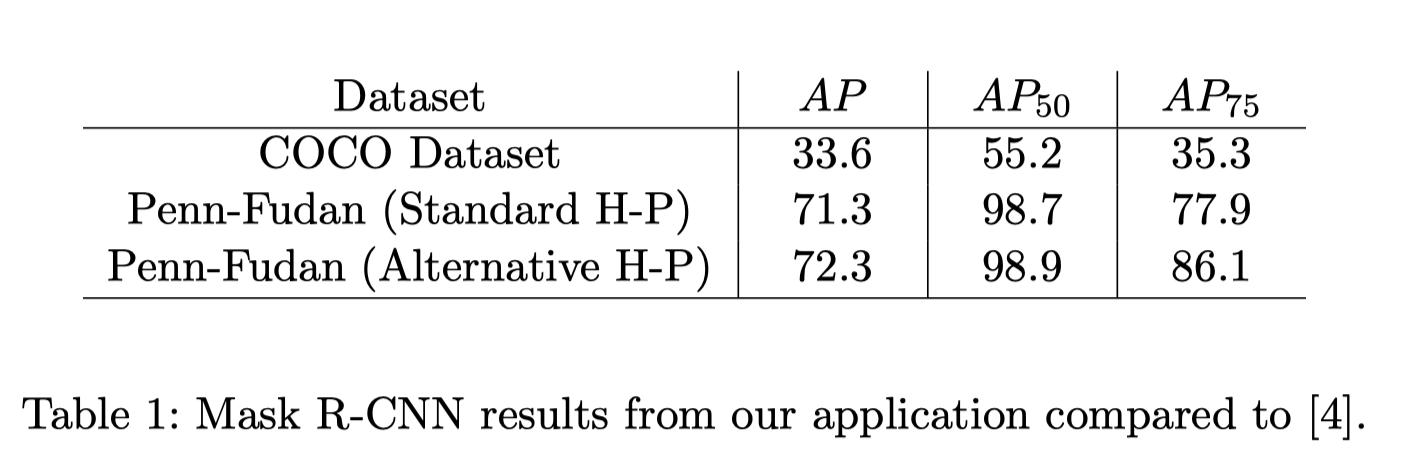

#### Printing results of the finetuning

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[8]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

We can combine the image and the mask to have a better visualization of the model

In [ ]:
col = torch.tensor([[255, 0, 60], [0, 200, 60], [150, 60, 0], [0, 0, 205], [250, 250, 0]])
mask_array = torch.zeros((img.size()[1:]))
image_array = img.mul(255)
combination = 0.6 * image_array

for i in range(5):
    try: 
        for j in range(3):
            combination[j] += 0.4 * col[i][j] * (prediction[0]['masks'][i, 0].mul(255) > 150).cpu() 
    except IndexError:
        pass

Image.fromarray(combination.permute(1, 2, 0).byte().numpy())

### Using SqueezeNet for Object recognition

We can use the pretrained SqueezeNet model as a backbone for the Faster R-CNN algorithm. The training hyperparameters are the stardard hyperparameters in the finetuning

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


 
# load a pre-trained model for classification and return
# only the features
backbone = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_1', pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For SqueezeNet, it's 1000
# so we need to add it here
backbone.out_channels = 512
 
# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
 
# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)
 
# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

# now get the number of input features for the mask classifier
#in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#hidden_layer = 256
# and replace the mask predictor with a new one
#model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                       hidden_layer,
#                                                       num_classes)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# The number of training epochs are chosen to 10 in this case
num_epochs = 10
metric_logger_squeeze = None
training_loss_squeeze = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metric_logger_squeeze = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    training_loss_squeeze[epoch] = metric_logger_squeeze.loss.global_avg
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the val dataset
    coco_squeeze_val = evaluate(model, data_loader_val, device=device)

# evaluate on the test dataset
coco_squeeze = evaluate(model, data_loader_test, device=device)

### Final comparison between finetuning and changing the backbone with SqueezeNet

In [ ]:
print(coco_squeeze.coco_eval["bbox"].stats[0])
plt.subplot(1, 1, 1)
plt.plot(training_loss, '-o', label='Training Loss with ResNet50')
plt.plot(training_loss_squeeze, '-o', label='Training Loss with SqueezeNet')
## Check bbox and segm losses training
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(ncol=2,loc='upper center')
plt.gcf().set_size_inches(15, 10)
plt.show()

In the training loss plot it can be seen that the error is smaller in the Mask R-CNN model with the ResNet-50 backbone. However the important metric is the average precision of the bounding boxes on the test set. The average precision is shown in this table taken from the paper.
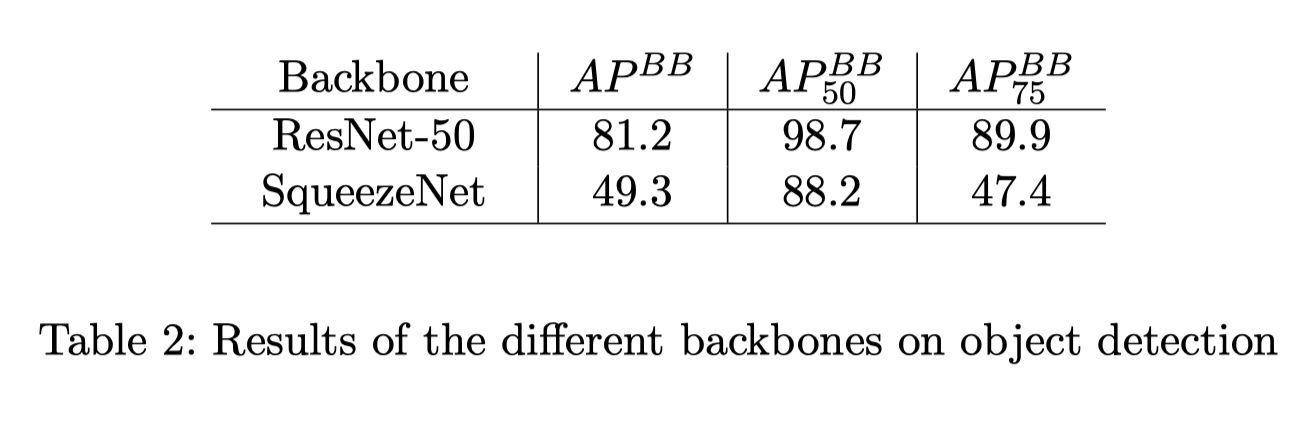


As explained in the paper, the SqueezeNet backbone has however a lower processing time and memory usage which could be useful for some applications. 

"The training time per epoch of the Mask R-CNN model with ResNet-50 was 01:45minutes while the time of the Faster R-CNN model with SqueezeNet was 00:21 minutes.The  test  time  per  image  was  0.3455  seconds  (2.89  FPS)  for  the  Mask  R-CNN  withResNet-50 and 0.0714 seconds (14 FPS) for the Faster R-CNN model with SqueezeNet."